In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

In [3]:
from models import simpleModel, stepModel, spatialModelFracConn, spatialModelNO2, spatialModelNO2alpha, minimize, msse, getMsseRelative
from plotting import plotSim, plotSimLks, plotSimLksCuml

In [4]:
data = gpd.read_file('./data/landkreise_no2_14d.json')
dateColNames = data.columns[5:-10]

## 1. Simple model

This model does ok for cumulative data.
But results are terrible if we try to use the same alpha for deaggregated LKs.
The reason is mostly n0: most LKs don't initially have any infections, so this model always predicts 0 for these LKs.
The simple model will always overestimate alpha, because it must compensate for those LKs that have n0 == 0.
We can expect the model to (obviously) underestimate all the LKs with n0 == 0 and to overestimate those with n0 != 0.

In [5]:
n_obs = data[dateColNames].values
nrPlaces, nrTimesteps = n_obs.shape
population = data['population'].values
Ks = population
n0 = n_obs[:, 0]

Let's first see how well that model does at predicting all of Germany.

In [31]:
n_obs_cuml = np.sum(n_obs, axis=0).reshape((1, nrTimesteps))
population_cuml = np.sum(population)
K_cuml = population_cuml
n0_cuml = n_obs_cuml[0]

In [32]:
results_simple_cuml = minimize(n_obs_cuml, simpleModel, [0.18], [(0.0001, 1.0000)], [1, nrTimesteps, K_cuml, n0_cuml], msse)

ValueError: could not broadcast input array from shape (37) into shape (1)

Now let's see how good the model is at predicting local values.

In [6]:
sseRelPop = getMsseRelative(population / 10000)
results_simple = minimize(n_obs, simpleModel, [0.18], [(0.0001, 1.0000)], [nrPlaces, nrTimesteps, Ks, n0], sseRelPop)
results_simple

      fun: 868937.278821977
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
  history: [{'paras': array([0.09755405]), 'error': 9077655.294260085}, {'paras': array([0.18000001]), 'error': 9077659.998928173}, {'paras': array([0.09755405]), 'error': 968528.0278317324}, {'paras': array([0.00010001]), 'error': 968528.0238766491}, {'paras': array([0.09755405]), 'error': 968468.1486155421}, {'paras': array([0.00025112]), 'error': 968468.1446453604}, {'paras': array([0.09755405]), 'error': 968226.3378648374}, {'paras': array([0.00085556]), 'error': 968226.3338337158}, {'paras': array([0.09755405]), 'error': 967221.4558312182}, {'paras': array([0.00327332]), 'error': 967221.451547425}, {'paras': array([0.09755405]), 'error': 962536.2731127578}, {'paras': array([0.01294435]), 'error': 962536.2676649737}, {'paras': array([0.09755405]), 'error': 928579.9421377575}, {'paras': array([0.05162848]), 'error': 928579.9294003239}, {'paras': array([0.09755405]), 'error': 34226726.49704827}, {'par

In [14]:
n_sim_simple = simpleModel(results_simple.x[0], nrPlaces, nrTimesteps, Ks, n0)
sseRelPop(n_obs, n_sim_simple)

868937.278821977

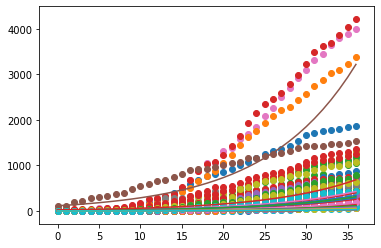

In [26]:
t = np.arange(nrTimesteps)
for i in range(0, nrPlaces):
    if n_obs[i, 0] != 0:
        plt.scatter(t, n_obs[i])
        plt.plot(t, n_sim_simple[i])

When we use the simple model to predict local values, we get ok predictions for all those places that have n0 != 0.
When we use instead the value of alpha that fits cumulated values, we get a massive overestimation of those local values.



In [27]:
n_sim_simple_x = simpleModel(0.17, nrPlaces, nrTimesteps, Ks, n0)
sseRelPop(n_obs, n_sim_simple_x)

5416871.984594022

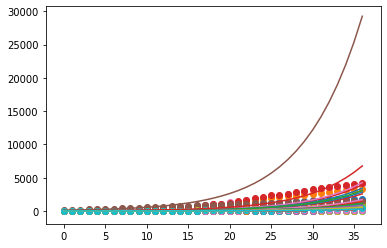

In [28]:
t = np.arange(nrTimesteps)
for i in range(0, nrPlaces):
    if n_obs[i, 0] != 0:
        plt.scatter(t, n_obs[i])
        plt.plot(t, n_sim_simple_x[i])

We can learn a few things from this:

  1. If we want to predict local values, we need to use a model that takes location and traffic explicitly into account.

  2. If we don't do that, we get a value for alpha that differs massively from the global one, because that non-global alpha is effectively only being calculated from the places that have n0 != 0

  3. Also note that these two models, although having the same sourcecode, have very different interpretations:
the cumulated model assumes perfect mixing between LKs, the deaggregated model assumes no mixing at all.

## 2. Simple model with step in $\alpha$

This model does better in fitting to cumulative data, but suffers from the same shortcomings as the simple model when it comes to deaggregated data.

## 3. Spatial model

## 4. Spatial model with connectivity reduction estimated from NO2

## 5. Spatial model with NO2 and localized $\alpha$